# Stock Classification via K-Means Clustering
## Contents
### Collect S&P 500 Data
### Clustering by Returns and Volatility (2D)
### Clustering by Price to Book Ratio, Returns, and Volatility (3D)
### Clustering by PE ratio and dividend rate (2D)

In [1]:
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import yfinance as yf
from matplotlib import pyplot as plt
import plotly.express as px

from scipy.cluster.vq import kmeans, vq
from sklearn.cluster import KMeans
from sklearn import preprocessing
from yellowbrick.cluster import SilhouetteVisualizer

from math import sqrt

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Collect S&P 500 data

In [2]:
# Link to S&P 500 tickers
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Read in the url and scrape ticker data
data_table = pd.read_html(sp500_url)
tickers = data_table[0]["Symbol"].values.tolist()
tickers = [s.replace(".", "-").replace(" ", "") for s in tickers]

# Download prices
start = "2020-01-01"
prices = yf.download(tickers=tickers, start=start)["Adj Close"]
prices

[*********************100%%**********************]  503 of 503 completed


,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,83.637688,28.982893,73.152657,74.197617,NaN,80.889473,43.400002,197.680679,334.429993,111.776894,...,141.295837,55.614132,57.528831,54.356968,76.070869,94.942886,140.511292,259.140015,45.666142,130.193283
2020-01-03,82.294807,27.548195,72.441452,73.493347,NaN,79.903374,43.349998,197.351440,331.809998,109.809196,...,139.200012,55.881596,57.066334,53.755436,76.518623,94.645515,140.144012,256.049988,45.021729,130.212738
2020-01-06,82.538071,27.219410,73.018684,74.073341,NaN,80.321999,43.520000,196.062714,333.709991,108.519081,...,138.924484,55.801353,57.504498,54.051422,76.023247,94.589783,139.334076,258.010010,44.473110,129.213028
2020-01-07,82.791084,27.119778,72.675270,73.650780,NaN,79.875458,43.160000,191.829758,333.390015,110.987961,...,139.583755,55.685448,57.033878,54.337868,75.737427,94.757034,139.211685,256.470001,44.203152,129.649796
2020-01-08,83.608490,27.737495,73.844345,74.172768,NaN,80.201057,42.730000,192.206009,337.869995,111.990356,...,140.459457,55.631958,56.173779,54.910748,75.994652,94.924286,140.878601,247.639999,44.638573,129.368317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-23,131.639999,14.000000,195.179993,167.500000,142.300003,114.000000,80.339996,369.859985,597.179993,201.369995,...,93.110001,59.189999,97.910004,35.490002,113.760002,131.750000,121.080002,256.089996,42.770000,188.100006
2024-01-24,129.779999,13.930000,194.500000,164.220001,141.190002,110.769997,80.129997,368.899994,606.479980,198.300003,...,94.290001,58.220001,99.599998,34.669998,111.699997,129.440002,120.519997,254.169998,44.139999,186.070007
2024-01-25,129.880005,15.360000,194.169998,165.130005,142.110001,112.449997,79.599998,371.940002,622.580017,197.300003,...,96.410004,58.889999,102.129997,35.049999,112.980003,130.220001,121.959999,256.989990,44.290001,187.320007


In [3]:
prices.dropna(axis="columns", inplace=True)
if prices.isna().sum().sum() == 0:
    print("All NaNs filtered.")

All NaNs filtered.


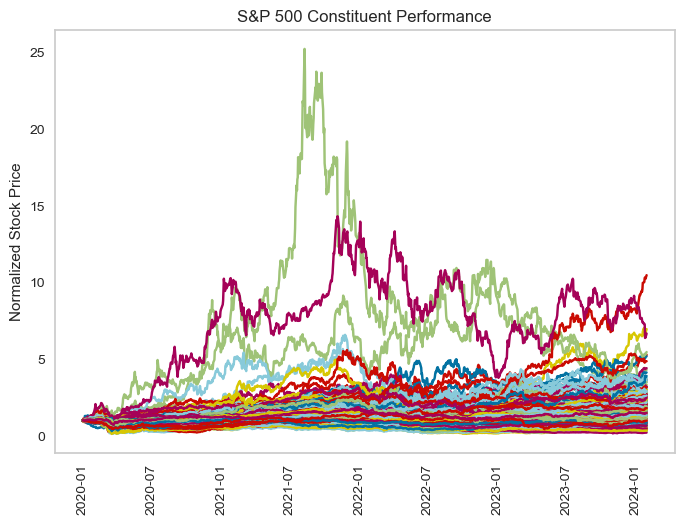

In [4]:
prices_norm = prices / prices.iloc[0]
plt.figure()
plt.plot(prices_norm)
# plt.yscale("log")
plt.grid()
plt.xticks(rotation="vertical")
plt.ylabel("Normalized Stock Price")
plt.title("S&P 500 Constituent Performance")
plt.show()

# Clustering by Returns and Volatility (2D)

In [5]:
# MaxAbsScaler class for normalization
max_abs_scaler = preprocessing.MaxAbsScaler()

returns = pd.DataFrame()
returns["Returns"] = prices.pct_change().mean() * 252
returns["Volatility"] = prices.pct_change().std() * sqrt(252)

# optional normalization between 0 and 1
returns["Returns"] = (returns["Returns"] - returns["Returns"].mean()) / (
    returns["Returns"].max() - returns["Returns"].min()
)
returns["Volatility"] = (returns["Volatility"] - returns["Volatility"].min()) / (
    returns["Volatility"].max() - returns["Volatility"].min()
)

X = np.asarray([np.asarray(returns["Returns"]), np.asarray(returns["Volatility"])]).T

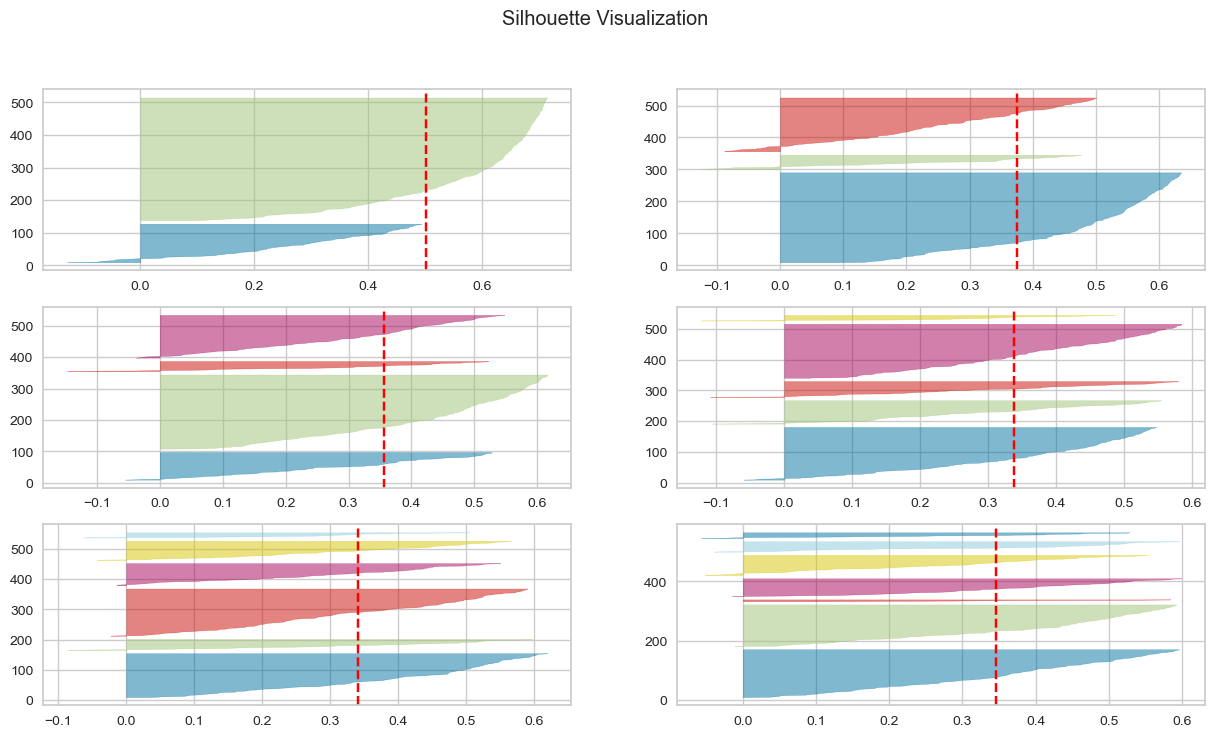

In [6]:
fig, ax = plt.subplots(3, 2, figsize=(15, 8))
fig.suptitle("Silhouette Visualization")
for i in range(2, 8):
    """
    Create KMeans instances for different number of clusters
    """
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=1000, random_state=42
    )
    q, mod = divmod(i, 2)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    visualizer.fit(X)

In [7]:
k = 3

# Computing K-Means with K = 5 clusters
centroids, _ = kmeans(X, k)

# Assign each sample to a cluster
idx, _ = vq(X, centroids)

# Dataframe with the tickers and the corresponding cluster
details = [(name, cluster) for name, cluster in zip(returns.index, idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ["Ticker", "Cluster"]

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df["Cluster"] = details_df["Cluster"]

# Rename columns
clusters_df.columns = ["Ticker", "Returns", "Volatility", "Cluster"]

In [8]:
# Visualize clusters based on return and volatility
fig = px.scatter(
    clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"]
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

In [9]:
# remove outliers (optional)
outliers = ["VFC", "MRNA", "TSLA", "NVDA", "ENPH", "BLDR"]
for outlier in outliers:
    returns.drop(outlier, inplace=True)

# optional renormalization
returns["Returns"] = (returns["Returns"] - returns["Returns"].min()) / (
    returns["Returns"].max() - returns["Returns"].min()
)
returns["Volatility"] = (returns["Volatility"] - returns["Volatility"].min()) / (
    returns["Volatility"].max() - returns["Volatility"].min()
)

X = np.asarray([np.asarray(returns["Returns"]), np.asarray(returns["Volatility"])]).T

In [10]:
# Computing K-Means
centroids, _ = kmeans(X, k)

# Assign each sample to a cluster
idx, _ = vq(X, centroids)

# Create a dataframe with the tickers and the clusters that's belong to
details = [(name, cluster) for name, cluster in zip(returns.index, idx)]
details_df = pd.DataFrame(details)

# Rename columns
details_df.columns = ["Ticker", "Cluster"]

# Create another dataframe with the tickers and data from each stock
clusters_df = returns.reset_index()

# Bring the clusters information from the dataframe 'details_df'
clusters_df["Cluster"] = details_df["Cluster"]

# Rename columns
clusters_df.columns = ["Ticker", "Returns", "Volatility", "Cluster"]

In [11]:
# Plot the clusters created using Plotly
fig = px.scatter(
    clusters_df, x="Returns", y="Volatility", color="Cluster", hover_data=["Ticker"]
)
fig.update(layout_coloraxis_showscale=False)
fig.show()

# Clustering by Price to Book Ratio, Returns, and Volatility (3D)

In [12]:
priceToBook_list = []
marketCap_list = []
tickers_clean = []
nan_tickers = []

for t in tickers:
    try:
        info = yf.Ticker(t).info
        priceToBook = info["priceToBook"]
        marketCap = info["marketCap"]

        priceToBook_list.append(priceToBook)
        marketCap_list.append(marketCap)
        tickers_clean.append(t)
    except:
        nan_tickers.append(t)

print("Tickers with no data:", nan_tickers)

Tickers with no data: ['MO', 'AAL', 'AON', 'AZO', 'BBWI', 'BA', 'BKNG', 'CAH', 'CLX', 'DPZ', 'ETSY', 'FICO', 'HCA', 'HLT', 'HPQ', 'LOW', 'MAR', 'MAS', 'MTCH', 'MCD', 'MCK', 'MTD', 'MSCI', 'ORLY', 'OTIS', 'PM', 'SBAC', 'STX', 'SBUX', 'TDG', 'VLTO', 'VRSN', 'WYNN', 'YUM']


In [13]:
# Create a datafrane to contain the data
priceToBook_df = pd.DataFrame()

# Add the ticker, priceToBook and marketCap data
priceToBook_df["Ticker"] = tickers_clean
priceToBook_df["priceToBook"] = priceToBook_list
priceToBook_df["marketCap"] = marketCap_list

# optional normalization
priceToBook_df["priceToBook"] = np.log(priceToBook_df["priceToBook"])
# priceToBook_df["priceToBook"] = (
#     priceToBook_df["priceToBook"] - priceToBook_df["priceToBook"].min()
# ) / (priceToBook_df["priceToBook"].max() - priceToBook_df["priceToBook"].min())
# priceToBook_df["marketCap"] = (
#     priceToBook_df["marketCap"] - priceToBook_df["marketCap"].min()
# ) / (priceToBook_df["marketCap"].max() - priceToBook_df["marketCap"].min())

priceToBook_df

,Ticker,priceToBook,marketCap
0,MMM,2.392411,53257752576
1,AOS,1.864231,12142988288
2,ABT,1.659132,196956012544
3,ABBV,3.175069,289389674496
4,ACN,2.171907,234087464960
...,...,...,...
464,XYL,1.011208,27328602112
465,ZBRA,1.473061,13144462336
466,ZBH,0.719525,25687943168
467,ZION,0.311420,6656514048


In [14]:
# Merge dataframes
clusters3d_df = pd.merge(clusters_df, priceToBook_df)

# Filter NaN values
clusters3d_df.dropna(inplace=True)

# Drop the column with the old clusterization
clusters3d_df.drop(["Cluster"], axis=1, inplace=True)

# Order columns
clusters3d_df = clusters3d_df[
    ["Ticker", "marketCap", "Returns", "Volatility", "priceToBook"]
]

clusters3d_df

,Ticker,marketCap,Returns,Volatility,priceToBook
0,A,38919720960,0.460312,0.157055,1.892888
1,AAPL,2964509949952,0.670853,0.203160,3.870544
2,ABBV,289389674496,0.565182,0.069236,3.175069
3,ABT,196956012544,0.398807,0.112644,1.659132
4,ACGL,29753004032,0.546420,0.242358,0.719067
...,...,...,...,...,...
453,XYL,27328602112,0.447477,0.194125,1.011208
454,ZBH,25687943168,0.240488,0.198694,0.719525
455,ZBRA,13144462336,0.342963,0.339719,1.473061
456,ZION,6656514048,0.404163,0.475823,0.311420


In [15]:
X = np.asarray(
    [
        np.asarray(clusters3d_df["Returns"]),
        np.asarray(clusters3d_df["Volatility"]),
        np.asarray(clusters3d_df["priceToBook"]),
    ]
).T

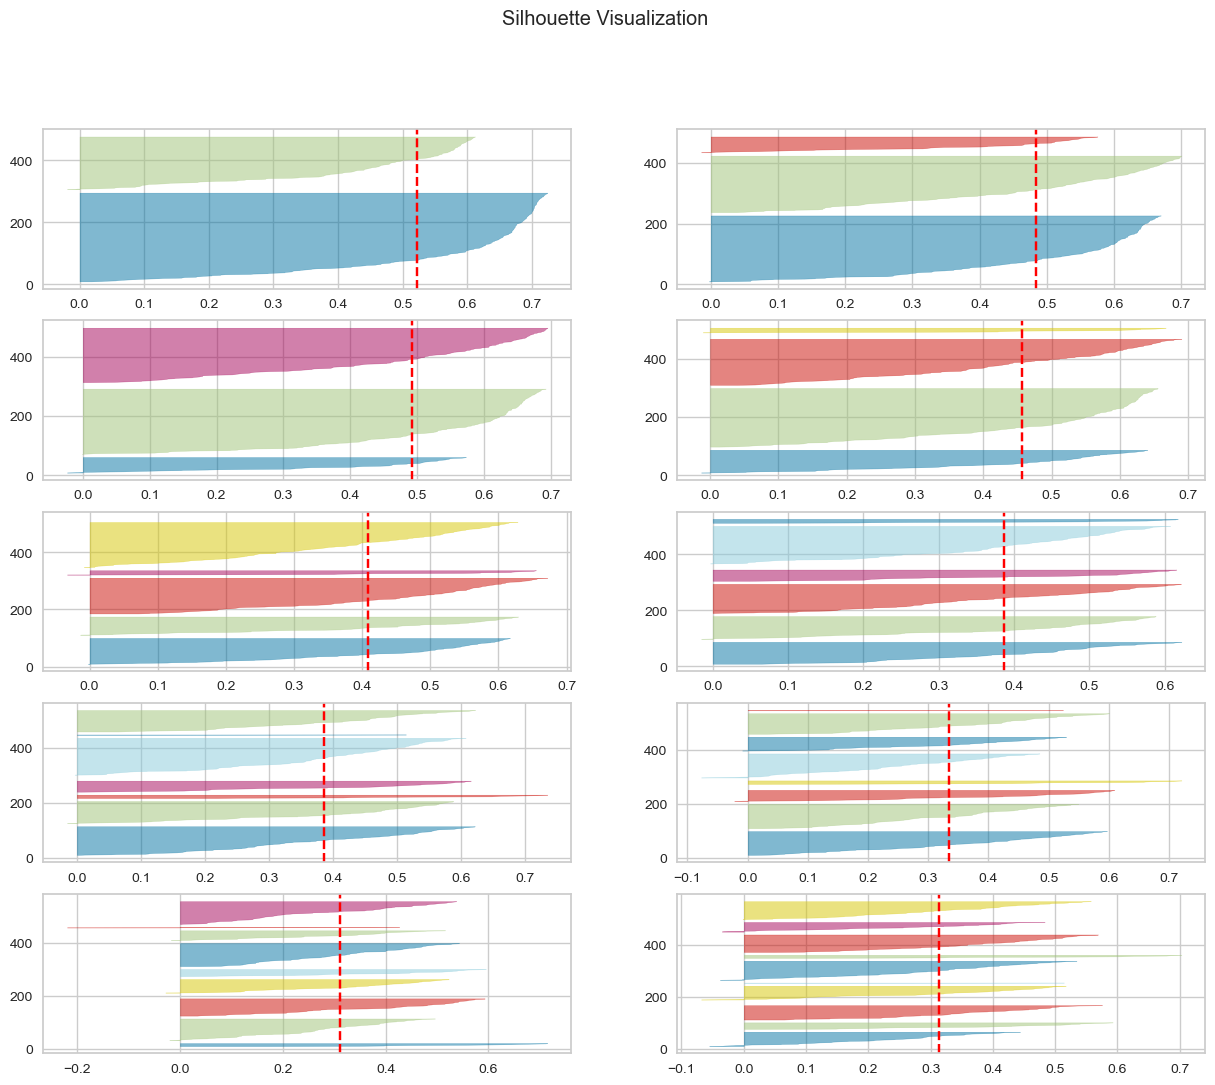

In [16]:
fig, ax = plt.subplots(5, 2, figsize=(15, 12))
fig.suptitle("Silhouette Visualization")
for i in range(2, 12):
    """
    Create KMeans instances for different number of clusters
    """
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=1000, random_state=42
    )
    q, mod = divmod(i, 2)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    visualizer.fit(X)

In [17]:
# Create clusters
k = 3  # can be adjusted
k_means_optimum = KMeans(n_clusters=k, init="k-means++", random_state=42)
y = k_means_optimum.fit_predict(X)

# Plot 3D graph with plotly
clusters3d_df["cluster"] = y

In [18]:
fig = px.scatter_3d(
    clusters3d_df,
    x="Returns",
    y="Volatility",
    z="priceToBook",
    color="cluster",
    hover_data=["Ticker"],
)
fig.show()

In [19]:
# Identify and remove the outliers stocks - optional
clusters3d_df.drop(
    clusters3d_df[(clusters3d_df["Ticker"] == "FTNT")].index, inplace=True
)
clusters3d_df.drop(
    clusters3d_df[(clusters3d_df["Ticker"] == "BRK-B")].index, inplace=True
)


# renormalize - optional
# priceToBook_df["priceToBook"] = (
#     priceToBook_df["priceToBook"] - priceToBook_df["priceToBook"].min()
# ) / (priceToBook_df["priceToBook"].max() - priceToBook_df["priceToBook"].min())
# priceToBook_df["marketCap"] = (
#     priceToBook_df["marketCap"] - priceToBook_df["marketCap"].min()
# ) / (priceToBook_df["marketCap"].max() - priceToBook_df["marketCap"].min())


# Recreate data to feed into the algorithm
X = np.asarray(
    [
        np.asarray(clusters3d_df["Returns"]),
        np.asarray(clusters3d_df["Volatility"]),
        np.asarray(clusters3d_df["priceToBook"]),
    ]
).T

In [20]:
# Initialize KMeans model with 3 clusters
k_means_optimum = KMeans(n_clusters=k, init="k-means++", random_state=42)

# Cluster data using KMeans and store labels in 'y'
y = k_means_optimum.fit_predict(X)

# Add 'cluster' column to dataframe with cluster labels from 'y'
clusters3d_df["cluster"] = y

In [21]:
# Create 3D scatter plot with plotly express, color-coded by cluster label and with 'Ticker' tooltip
fig = px.scatter_3d(
    clusters3d_df,
    x="priceToBook",
    y="Returns",
    z="Volatility",
    color="cluster",
    hover_data=["Ticker"],
)
fig.show()

# Clustering by PE ratio and dividend rate (2D)

In [22]:
# Download trailing PE and dividend rate
trailingPE_list = []
dividendRate_list = []
marketCap_list = []

for t in tickers:
    tick = yf.Ticker(t)
    ticker_info = tick.info

    try:
        trailingPE = ticker_info["trailingPE"]
        trailingPE_list.append(trailingPE)
    except:
        trailingPE_list.append(np.nan)

    try:
        dividendRate = ticker_info["dividendRate"]
        dividendRate_list.append(dividendRate)
    except:
        dividendRate_list.append(np.nan)

    try:
        marketCap = ticker_info["marketCap"]
        marketCap_list.append(marketCap)
    except:
        marketCap_list.append(np.nan)

In [23]:
# Create a datafrane to contain the data
sp_features_df = pd.DataFrame()

# Add the ticker, trailingPE and dividendRate data
sp_features_df["Ticker"] = tickers
sp_features_df["trailingPE"] = trailingPE_list
sp_features_df["dividendRate"] = dividendRate_list
sp_features_df["marketCap"] = marketCap_list

# Shares with 'na' as dividend rate has no dividend so we have to assign 0 as dividend rate in this cases
sp_features_df["dividendRate"] = sp_features_df["dividendRate"].fillna(0)

# filter shares with NaN
df_mask = sp_features_df["trailingPE"] != np.nan
sp_features_df = sp_features_df[df_mask]

# Convert trailingPE numbers to float type
sp_features_df["trailingPE"] = sp_features_df["trailingPE"].astype(float)

# Removes the rows that contains NULL values
sp_features_df = sp_features_df.dropna()

sp_features_df

,Ticker,trailingPE,dividendRate,marketCap
1,AOS,40.621890,1.28,12142988288
2,ABT,34.800613,2.20,196956012544
3,ABBV,44.906850,6.20,289389674496
4,ACN,34.569443,5.16,234087464960
5,ADBE,53.183964,0.00,284863954944
...,...,...,...,...
498,YUM,24.866667,2.68,36594208768
499,ZBRA,28.563616,0.00,13144462336
500,ZBH,54.389380,0.96,25687943168
501,ZION,10.328736,1.64,6656514048


In [24]:
# Filter companies with ultra-high PE ratios
df_mask = (sp_features_df["trailingPE"] < 200) & (sp_features_df["dividendRate"] < 5)
sp_features_df = sp_features_df[df_mask]

In [25]:
# MaxAbsScaler class for normalization
max_abs_scaler = preprocessing.MaxAbsScaler()

# Extract the 'trailingPE' column and reshape it to a column vector
trailingPE_array = np.array(sp_features_df["trailingPE"].values).reshape(-1, 1)

# Extract the 'dividendRate' column and reshape it to a column vector
dividendRate_array = np.array(sp_features_df["dividendRate"].values).reshape(-1, 1)

# Extract the 'marketCap' column and reshape it to a column vector
marketCap_array = np.array(sp_features_df["marketCap"].values).reshape(-1, 1)

# Apply the MaxAbsScaler and store the normalized values in new columns
sp_features_df["trailingPE_norm"] = max_abs_scaler.fit_transform(trailingPE_array)
sp_features_df["dividendRate_norm"] = max_abs_scaler.fit_transform(dividendRate_array)
sp_features_df["marketCap_norm"] = max_abs_scaler.fit_transform(marketCap_array)

In [26]:
X = np.asarray(
    [
        np.asarray(sp_features_df["trailingPE_norm"]),
        np.asarray(sp_features_df["dividendRate_norm"]),
    ]
).T

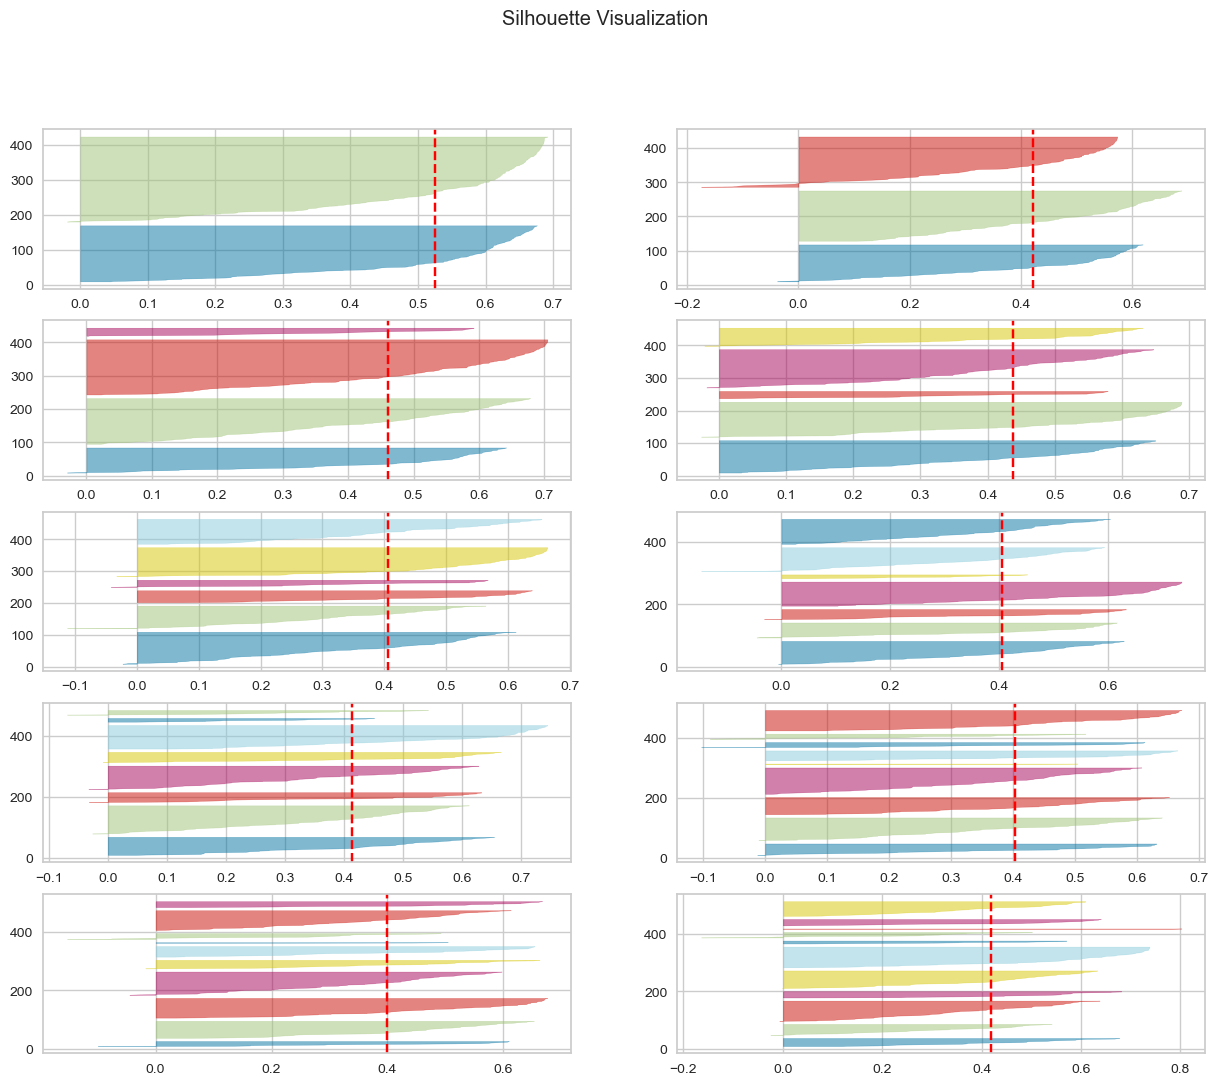

In [27]:
fig, ax = plt.subplots(5, 2, figsize=(15, 12))
fig.suptitle("Silhouette Visualization")
for i in range(2, 12):
    """
    Create KMeans instances for different number of clusters
    """
    km = KMeans(
        n_clusters=i, init="k-means++", n_init=10, max_iter=1000, random_state=42
    )
    q, mod = divmod(i, 2)
    """
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    """
    visualizer = SilhouetteVisualizer(km, colors="yellowbrick", ax=ax[q - 1][mod])
    visualizer.fit(X)

In [28]:
k = 4  # 3 or 4 could be chosen

# Computing K-Means with K = 4 clusters
centroids, _ = kmeans(X, k)

# Assign each sample to a cluster
idx, _ = vq(X, centroids)

# Create a dataframe with the tickers and the corresponding clusters
details = [(name, cluster) for name, cluster in zip(sp_features_df.index, idx)]
details_df = pd.DataFrame(details)

clusters_df = pd.DataFrame()
clusters_df["Ticker"] = sp_features_df["Ticker"]
clusters_df["trailingPE_norm"] = sp_features_df["trailingPE_norm"]
clusters_df["dividendRate_norm"] = sp_features_df["dividendRate_norm"]
clusters_df["marketCap_norm"] = sp_features_df["marketCap_norm"]
clusters_df["Cluster"] = details_df[1].values

In [29]:
# Plot the clusters created using Plotly
fig = px.scatter(
    clusters_df,
    x="dividendRate_norm",
    y="trailingPE_norm",
    color="Cluster",
    hover_data=["Ticker"],
)
fig.update(layout_coloraxis_showscale=False)
fig.show()